# YASA
This example script demonstrates how to use YASA to automatically detect sleep spindles.

Please make sure to install YASA first by following the procedure described at: https://github.com/raphaelvallat/yasa

In [1]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

import yasa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

## 1. Spindles detection
To illustrate the functions, we load 30 seconds of N2 sleep on a single
channel central EEG data. The sampling rate is 200 Hz.

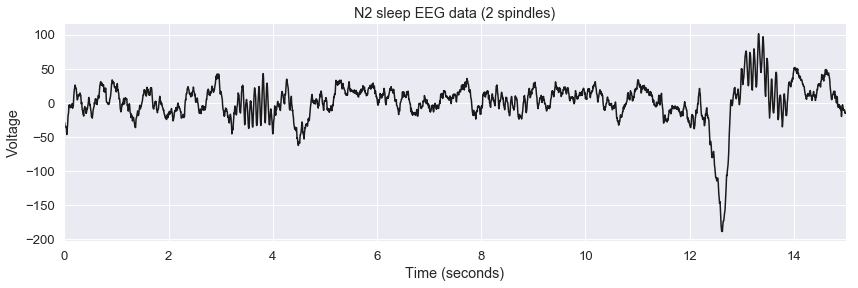

In [2]:
# Load data
data = np.loadtxt('data_N2_spindles_15sec_200Hz.txt')

# Define sampling frequency and time vector
sf = 200.
times = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.plot(times, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([times.min(), times.max()])
plt.title('N2 sleep EEG data (2 spindles)')
sns.despine()

We can clearly see that there are two clean spindles on this 15-seconds epoch. The first one starting at around 3.5 seconds and the second one starting around 13 seconds.

Let's detect these spindles using yasa:

In [3]:
sp = yasa.spindles_detect(data, sf)
sp

,Start,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Confidence
0,3.37,4.00,0.63,82.144897,20.560622,2.428862,0.527891,12.724772,8.0,0.687500,high
2,13.17,13.82,0.65,102.210795,25.404009,2.579672,0.212348,12.128554,7.0,0.363636,medium


The algorithm successfully identified the two spindles. The output of yasa `spindles_detect` function is a pandas DataFrame where each row is a spindle and each column a parameter of this spindle. The different parameters are described in the documentation:

In [4]:
yasa.spindles_detect?

Signature: yasa.spindles_detect(data, sf, freq_sp=(11, 16), duration=(0.3, 2.5), freq_broad=(0.5, 30), min_distance=500, thresh={'abs_pow': 1.25, 'rel_pow': 0.2, 'rms': 95, 'corr': 0.69})
Docstring:
Spindles detection using a custom algorithm based on
Lacourse et al. 2018.

This script will be more precise if applied only on artefact-free
NREM epochs. However, it should also work relatively well with full-night
recordings.

Parameters
----------
data : array_like
    Single-channel data
sf : float
    Sampling frequency of the data in Hz.
freq_sp : tuple or list
    Spindles frequency range. Default is 11 to 16 Hz.
freq_broad : tuple or list
    Broad band frequency of interest.
    Default is 0.5 to 30 Hz.
min_distance : int
    If two spindles are closer than min_distance (in ms), they are merged
    into a single spindles. Default is 500 ms.
thresh : dict
    Detection thresholds::

        'abs_pow' : Absolute log10(power) of the sigma-filtered signal.
        'rel_pow' : Relative 

### 1.1 Plot an overlay of our detected spindles
First we need to create a boolean array of the same size of data indicating for each sample if this sample is part of a spindles or not. This is done using the `get_bool_vector` function.

In [5]:
# Let's get a bool vector indicating for each sample
bool_spindles = yasa.get_bool_vector(data, sf, sp)

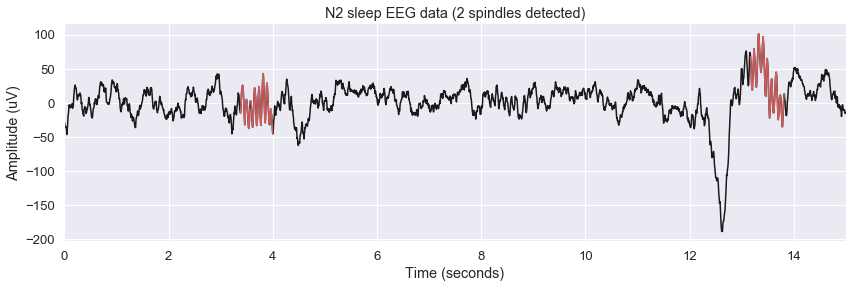

In [10]:
# Now let's plot
spindles_highlight = data * bool_spindles
spindles_highlight[spindles_highlight == 0] = np.nan

plt.figure(figsize=(14, 4))
plt.plot(times, data, 'k')
plt.plot(times, spindles_highlight, 'indianred')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (uV)')
plt.xlim([0, times[-1]])
plt.title('N2 sleep EEG data (2 spindles detected)')
sns.despine()
plt.savefig('detection.png', dpi=300, bbox_inches='tight')

## 2. Behind the black box: the YASA algorithm step-by-step

### Threshold 1: Relative power in the sigma band

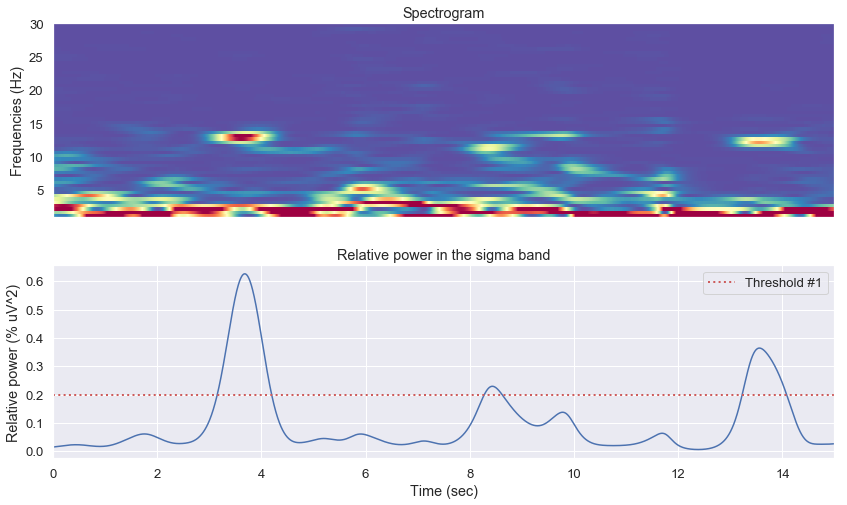

In [7]:
f, t, Sxx = yasa.main.stft_power(data, sf, window=2, step=.05, band=(1, 30), norm=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
plt.subplots_adjust(hspace=.25)
im = ax1.pcolormesh(t, f, Sxx, cmap='Spectral_r', vmax=0.2)
ax1.set_title('Spectrogram')
ax1.set_ylabel('Frequencies (Hz)')

idx_sigma = np.logical_and(f >= 11, f <= 16)


rel_pow = Sxx[idx_sigma].sum(0)
ax2.plot(t, rel_pow)
ax2.set_ylabel('Relative power (% uV^2)')
ax2.set_xlim(t[0], t[-1])
ax2.set_xlabel('Time (sec)')
ax2.axhline(0.2, ls=':', lw=2, color='indianred', label='Threshold #1')
plt.legend()
_ = ax2.set_title('Relative power in the sigma band')

In [8]:
%timeit yasa.main.stft_power(data, sf, window=2, step=.05, band=(1, 30), norm=True)

6.08 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Threshold 2: Moving correlation

From [Lacourse et al. 2018](https://www.sciencedirect.com/science/article/pii/S0165027018302504)

For all the remaining detection threshold, we'll be using the bandpass filtered signal.

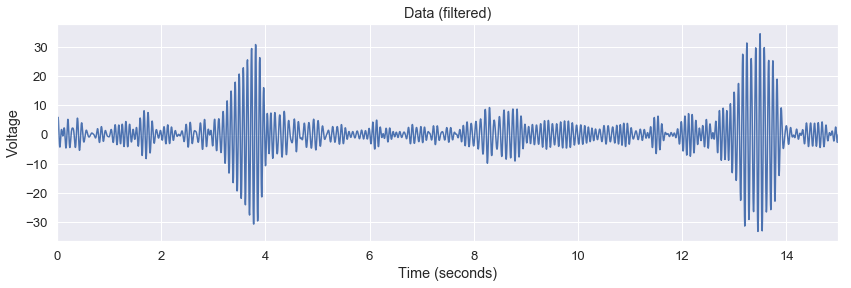

In [9]:
from mne.filter import filter_data
data_sigma = filter_data(data, sf, 12, 15, method='fir', verbose=0)

plt.figure(figsize=(14, 4))
plt.plot(times, data_sigma)
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.title('Data (filtered)')
_ = plt.xlim(0, times[-1])

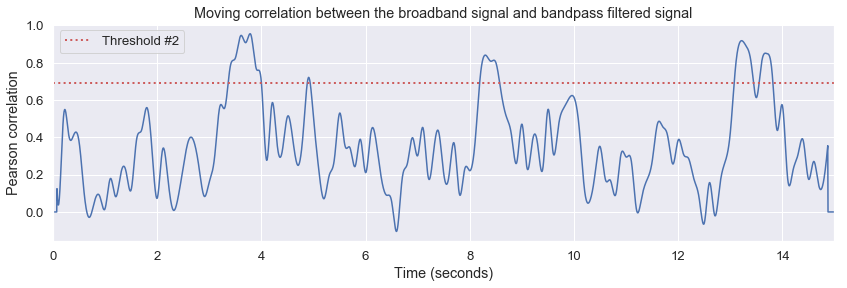

In [10]:
t, mcorr = yasa.main.moving_transform(data_sigma, data, sf, window=.3, step=.1, method='corr', interp=True)

plt.figure(figsize=(14, 4))
plt.plot(times, mcorr)
plt.xlabel('Time (seconds)')
plt.ylabel('Pearson correlation')
plt.axhline(0.69, ls=':', lw=2, color='indianred', label='Threshold #2')
plt.legend()
plt.title('Moving correlation between the broadband signal and bandpass filtered signal')
_ = plt.xlim(0, times[-1])

In [11]:
%timeit yasa.main.moving_transform(data_sigma, data, sf, window=.3, step=.1, method='corr', interp=True)

810 µs ± 3.51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Threshold 3: Moving root mean square (RMS)

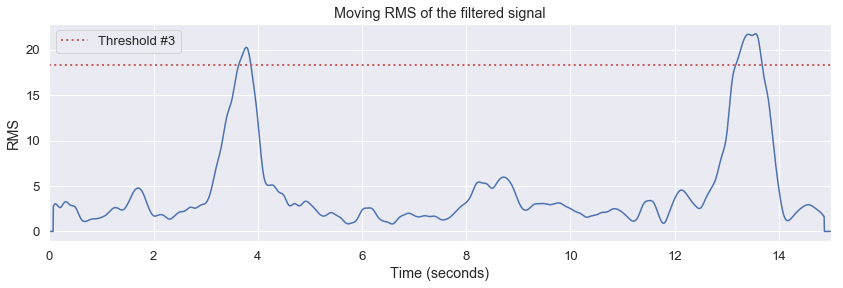

In [12]:
t, mrms = yasa.main.moving_transform(data_sigma, data, sf, window=.3, step=.1, method='rms', interp=True)

plt.figure(figsize=(14, 4))
plt.plot(times, mrms)
plt.xlabel('Time (seconds)')
plt.ylabel('RMS')
plt.axhline(np.percentile(mrms, 95), ls=':', lw=2, color='indianred', label='Threshold #3')
plt.legend()
plt.title('Moving RMS of the filtered signal')
_ = plt.xlim(0, times[-1])

In [13]:
%timeit yasa.main.moving_transform(data_sigma, data, sf, window=.3, step=.1, method='rms', interp=True)

601 µs ± 5.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Threshold 4: Absolute log10(power)

From [Lacourse et al. 2018](https://www.sciencedirect.com/science/article/pii/S0165027018302504)

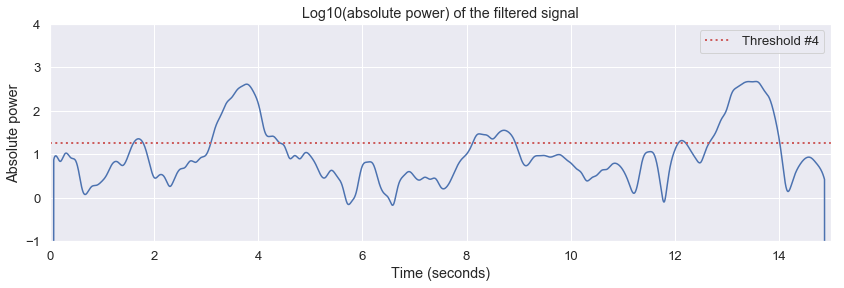

In [14]:
mms = np.square(mrms)
mms[mms <= 0] = 0.00000000001
abs_pow = np.log10(mms)

plt.figure(figsize=(14, 4))
plt.plot(times, abs_pow)
plt.xlabel('Time (seconds)')
plt.ylabel('Absolute power')
plt.axhline(1.25, ls=':', lw=2, color='indianred', label='Threshold #4')
plt.legend()
plt.title('Log10(absolute power) of the filtered signal')
plt.ylim(-1, 4)
_ = plt.xlim(0, times[-1])

### Decision function
Every sample of the data that validate at least 3 of these 4 threshold is considered as a potential sleep spindles.

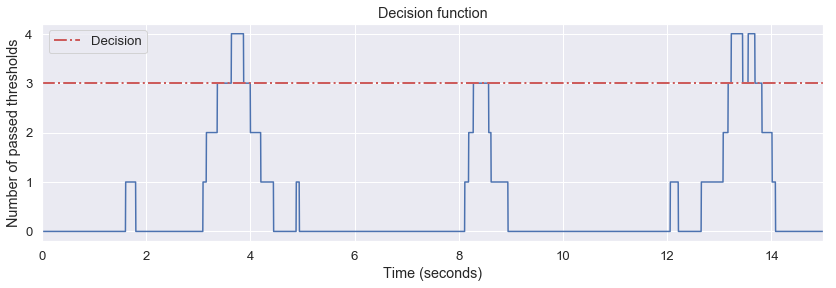

In [15]:
idx_rel_pow = (rel_pow >= 0.2).astype(int)
idx_mcorr = (mcorr >= 0.69).astype(int)
idx_mrms = (mrms >= np.percentile(mrms, 95)).astype(int)
idx_abs_pow = (abs_pow >= 1.25).astype(int)
idx_sum = (idx_abs_pow + idx_rel_pow + idx_mcorr + idx_mrms).astype(int)

plt.figure(figsize=(14, 4))
plt.plot(times, idx_sum)
plt.xlabel('Time (seconds)')
plt.ylabel('Number of passed thresholds')
plt.axhline(3, ls='-.', lw=2, color='indianred', label='Decision')
plt.legend()
plt.title('Decision function')
_ = plt.xlim(0, times[-1])

### Morphological criteria
1. Finally, spindles that are too close to each other (less than 500 ms) are merged together
2. Spindles that are either too short or too long are removed
3. For each remaining spindle, a bunch of parameters are extracted.
    - Start and end time in seconds
    - Duration in seconds
    - Amplitude in uV
    - Root mean square in uV
    - Mean absolute power (log10-transformed)
    - Mean relative power (from 0 to 1)
    - Median frequency (extracted using the analytical signal of an Hilbert transform)
    - Number of oscillations
    - Symmetry (indicates where is the most prominent peak on a 0 to 1 vector where 0 is the beginning of the spindles and 1 the end. Ideally it should be around 0.5)
    - Confidence: a high-confidence spindle is a spindle that met all four criteria for more than 75% of its total duration.

In [16]:
yasa.spindles_detect(data, sf)

,Start,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Confidence
0,3.37,4.00,0.63,82.144897,20.560622,2.428862,0.527891,12.724772,8.0,0.687500,high
2,13.17,13.82,0.65,102.210795,25.404009,2.579672,0.212348,12.128554,7.0,0.363636,medium


In [17]:
%timeit yasa.spindles_detect(data, sf)

12.1 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Safety checks

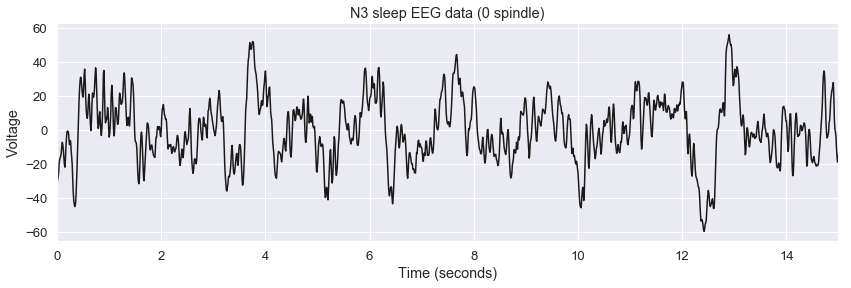

In [18]:
data_no_sp = np.loadtxt('data_N3_no-spindles_30sec_100Hz.txt')
sf_no_sp = 100
times_no_sp = np.arange(data_no_sp.size) / sf_no_sp

plt.figure(figsize=(14, 4))
plt.plot(times_no_sp, data_no_sp, 'k')
plt.xlim(0, times_no_sp.max())
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([times.min(), times.max()])
plt.title('N3 sleep EEG data (0 spindle)')
sns.despine()

In [19]:
sp_params = yasa.spindles_detect(data_no_sp, sf_no_sp)
sp_params

No spindle were found in data. Returning None.
